In [1]:
# Colab cell 1: install (if needed) and imports
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
# remove the line above if PyTorch is already present or if you want default Colab install

import os
import time
import random
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

print("torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

torch: 2.8.0+cu126
Device: cuda


In [2]:
# Colab cell 2: optional - mount drive to persist checkpoints/plots
from google.colab import drive
DRIVE_MOUNT = True  # set False if you don't want to mount drive

if DRIVE_MOUNT:
    drive.mount('/content/drive')
    BASE_DIR = Path("/content/drive/MyDrive/quant_task_baseline")
else:
    BASE_DIR = Path("/content/baseline_output")

BASE_DIR.mkdir(parents=True, exist_ok=True)
print("Base output dir:", BASE_DIR)

Mounted at /content/drive
Base output dir: /content/drive/MyDrive/quant_task_baseline


##Baseline Model Training

In [3]:
# Colab cell 3: set seeds & hyperparams
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Hyperparameters - adjust if needed
NUM_EPOCHS = 50           # change to 50/100 if you want more
BATCH_SIZE = 128          # Colab GPU should handle 128 or 256 depending on availability
NEW_LR = 0.1   # larger LR to test
WEIGHT_DECAY = 5e-4
MOMENTUM = 0.9
NUM_WORKERS = 2

print("Hyperparams:", {"epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE, "lr": NEW_LR})

Hyperparams: {'epochs': 50, 'batch_size': 128, 'lr': 0.1}


In [4]:
import torch.nn as nn
import torch.nn.init as init

class VGG11_BN_CIFAR(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # conv2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # conv3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # conv4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # conv5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate model
model = VGG11_BN_CIFAR(num_classes=100).to(device)

# weight init
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        init.ones_(m.weight)
        init.zeros_(m.bias)

model.apply(init_weights)
print("Created VGG11-BN and initialized weights. Device:", device)

Created VGG11-BN and initialized weights. Device: cuda


In [5]:
# Colab cell 4: data transforms and loaders
mean = (0.5071, 0.4865, 0.4409)  # CIFAR-100 mean
std  = (0.2673, 0.2564, 0.2761)  # CIFAR-100 std

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_set  = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

NUM_WORKERS = 2
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Train size:", len(train_set), "Val size:", len(test_set))

100%|██████████| 169M/169M [00:13<00:00, 12.2MB/s]


Train size: 50000 Val size: 10000


###Train Baseline Model

In [ ]:
# optimizer + scheduler (standard CIFAR setup)
LR = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)  # NUM_EPOCHS from earlier cell

# AMP
use_amp = True if device.type == 'cuda' else False
scaler = torch.amp.GradScaler(enabled=use_amp)

print("Optimizer: SGD lr=0.1 momentum=0.9 weight_decay=5e-4; AMP:", use_amp)

In [ ]:
# quick warm-up: 1 epoch
model.train()
running_loss = 0.0
running_acc = 0.0
cnt = 0
print_every = 50
t0 = time.time()
for i, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else None, enabled=use_amp):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    _, preds = outputs.max(1)
    batch_acc = (preds == targets).float().mean().item()
    running_loss += loss.item()
    running_acc += batch_acc
    cnt += 1

    if (i+1) % print_every == 0:
        print(f"iter {i+1} avg_loss={running_loss/cnt:.4f} avg_acc={100*(running_acc/cnt):.2f}% last_loss={loss.item():.4f} last_acc={100*batch_acc:.2f}%")
    # run just 1 epoch; break early for speed if you want, e.g., after 500 iters:
    # if (i+1) >= 500: break

t1 = time.time()
print("Warm-up epoch done in {:.1f}s  avg_loss={:.4f} avg_acc={:.2f}%".format(t1-t0, running_loss/cnt, 100*(running_acc/cnt)))

In [ ]:
# Full training loop (resume from scratch). Adjust NUM_EPOCHS if you want longer training.
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_acc = 0.0
start_time = time.time()

for epoch in range(1, NUM_EPOCHS+1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    # train
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    pbar = tqdm(train_loader, desc="Train", leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else None, enabled=use_amp):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        train_correct += preds.eq(targets).sum().item()
        train_total += inputs.size(0)
        pbar.set_postfix(loss=train_loss/train_total, acc=100.*train_correct/train_total)

    # val
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        pbar = tqdm(val_loader, desc="Val", leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            with torch.amp.autocast(device_type='cuda' if device.type=='cuda' else None, enabled=use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(targets).sum().item()
            val_total += inputs.size(0)

    train_loss_epoch = train_loss / train_total
    train_acc_epoch = 100. * train_correct / train_total
    val_loss_epoch = val_loss / val_total
    val_acc_epoch = 100. * val_correct / val_total

    history["train_loss"].append(train_loss_epoch)
    history["train_acc"].append(train_acc_epoch)
    history["val_loss"].append(val_loss_epoch)
    history["val_acc"].append(val_acc_epoch)

    print(f"Epoch {epoch}: Train Loss {train_loss_epoch:.4f} Acc {train_acc_epoch:.2f}% | Val Loss {val_loss_epoch:.4f} Acc {val_acc_epoch:.2f}%")

    # scheduler step
    scheduler.step()

    # checkpoint best
    if val_acc_epoch > best_acc:
        best_acc = val_acc_epoch
        ckpt_path = BASE_DIR / f"vgg11bn_best.pth"
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optim_state_dict": optimizer.state_dict(),
            "val_acc": val_acc_epoch,
            "history": history
        }, ckpt_path)
        print("Saved best model to", ckpt_path)

total_time = time.time() - start_time
print("Training finished in {:.2f} minutes. Best val acc: {:.2f}%".format(total_time/60, best_acc))

##Baseline Model Evaluation

In [ ]:
# Colab cell 4: data transforms and loaders
mean = (0.5071, 0.4865, 0.4409)  # CIFAR-100 mean
std  = (0.2673, 0.2564, 0.2761)  # CIFAR-100 std

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_set  = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

NUM_WORKERS = 2
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Train size:", len(train_set), "Val size:", len(test_set))

Train size: 50000 Val size: 10000


In [ ]:
# Cell A: evaluate saved best model in detail
import torch, numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

ckpt = torch.load(BASE_DIR / "vgg11bn_best.pth", map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()

# Overall accuracy & collect preds/labels
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, targets in tqdm(val_loader, desc="Eval"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(targets.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
overall_acc = 100.0 * (all_preds == all_labels).mean()
print(f"Overall accuracy on test set: {overall_acc:.2f}%")

# Per-class accuracy
num_classes = 100
class_correct = np.zeros(num_classes, dtype=int)
class_total = np.zeros(num_classes, dtype=int)
for p, t in zip(all_preds, all_labels):
    for pred, true in zip(np.atleast_1d(p), np.atleast_1d(t)):
        class_total[true] += 1
        if pred == true:
            class_correct[true] += 1
per_class_acc = 100.0 * class_correct / class_total
df = pd.DataFrame({"class_idx": np.arange(num_classes), "acc": per_class_acc})
df.to_csv(BASE_DIR / "per_class_acc.csv", index=False)
print("Saved per-class accuracy to", BASE_DIR / "per_class_acc.csv")
# Optionally show top-5 easiest / hardest classes
print("Mean per-class acc: {:.2f}%".format(per_class_acc.mean()))
print("Top-5 easiest classes:", df.sort_values("acc", ascending=False).head(5).to_dict('records'))
print("Top-5 hardest classes:", df.sort_values("acc", ascending=True).head(5).to_dict('records'))

# Confusion matrix (optional - can be large)
cm = confusion_matrix(all_labels, all_preds)
np.save(BASE_DIR / "confusion_matrix.npy", cm)
print("Saved confusion matrix to", BASE_DIR / "confusion_matrix.npy")

Eval: 100%|██████████| 79/79 [00:03<00:00, 26.12it/s]


Overall accuracy on test set: 68.91%
Saved per-class accuracy to /content/drive/MyDrive/quant_task_baseline/per_class_acc.csv
Mean per-class acc: 68.91%
Top-5 easiest classes: [{'class_idx': 68, 'acc': 96.0}, {'class_idx': 48, 'acc': 92.0}, {'class_idx': 76, 'acc': 91.0}, {'class_idx': 60, 'acc': 90.0}, {'class_idx': 94, 'acc': 89.0}]
Top-5 hardest classes: [{'class_idx': 46, 'acc': 41.0}, {'class_idx': 10, 'acc': 42.0}, {'class_idx': 72, 'acc': 42.0}, {'class_idx': 55, 'acc': 46.0}, {'class_idx': 64, 'acc': 47.0}]
Saved confusion matrix to /content/drive/MyDrive/quant_task_baseline/confusion_matrix.npy


In [ ]:
# Cell B: save float32 model & report sizes
import os, pathlib
# Save float32 checkpoint (already saved, but ensure a standalone pth)
torch.save(model.state_dict(), BASE_DIR / "vgg11bn_best_float32_weights.pth")
size_bytes = os.path.getsize(str(BASE_DIR / "vgg11bn_best_float32_weights.pth"))
print("Float32 weights size: {:.2f} MB".format(size_bytes / (1024*1024)))

# Optionally save full scriptable model (TorchScript) for inference
model_cpu = model.to('cpu').eval()
scripted = torch.jit.script(model_cpu)
scripted_path = BASE_DIR / "vgg11bn_scripted.pt"
scripted.save(scripted_path)
print("Saved TorchScript model to", scripted_path)
print("TorchScript size: {:.2f} MB".format(os.path.getsize(str(scripted_path)) / (1024*1024)))

# move model back to device
model.to(device)

Float32 weights size: 36.43 MB
Saved TorchScript model to /content/drive/MyDrive/quant_task_baseline/vgg11bn_scripted.pt
TorchScript size: 36.46 MB


VGG11_BN_CIFAR(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): M

In [ ]:
# Cell C: latency & throughput measurements
import time, torch

model.eval()
warmup = 30
iters = 300
batch_size = 1

# single image latency (batch_size=1)
dummy_iter = iter(val_loader)
inputs, _ = next(dummy_iter)
inputs = inputs[:batch_size].to(device)

# warmup
with torch.no_grad():
    for _ in range(warmup):
        _ = model(inputs)

# timed runs
torch.cuda.synchronize()
t0 = time.time()
with torch.no_grad():
    for _ in range(iters):
        _ = model(inputs)
torch.cuda.synchronize()
latency = (time.time() - t0) / iters * 1000.0  # ms
print(f"Single-image latency: {latency:.3f} ms (avg over {iters} runs)")

# throughput for batch=64 (optional)
batch_size = 64
# prepare a batch
batch_inputs, _ = next(iter(val_loader))
batch_inputs = batch_inputs[:batch_size].to(device)
# warmup
with torch.no_grad():
    for _ in range(10):
        _ = model(batch_inputs)
torch.cuda.synchronize()
t0 = time.time()
with torch.no_grad():
    for _ in range(50):
        _ = model(batch_inputs)
torch.cuda.synchronize()
elapsed = time.time() - t0
throughput = (50 * batch_size) / elapsed
print(f"Throughput (batch={batch_size}): {throughput:.1f} images/sec")

Single-image latency: 1.607 ms (avg over 300 runs)
Throughput (batch=64): 11932.0 images/sec


##PTQ

In [ ]:
# Create calibration DataLoader (for PTQ calibration)
import torch
from torch.utils.data import DataLoader, Subset
import numpy as np

# We'll sample a small subset of training data for calibration (≈ 2k examples)
calib_subset_size = 2000
calib_indices = np.random.choice(len(train_set), size=calib_subset_size, replace=False)
calib_dataset = Subset(train_set, calib_indices)

calib_loader = DataLoader(
    calib_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

print(f"Calibration loader ready with {len(calib_dataset)} samples.")

Calibration loader ready with 2000 samples.


In [ ]:
# PTQ Cell 1: helpers
import time, os, torch
import numpy as np
from pathlib import Path

def evaluate_model(model, loader, device='cuda', max_batches=None):
    """Return (top1_acc, loss_avg) and optionally collect softmax logits if needed."""
    model.eval()
    model.to(device)
    total = 0
    correct = 0
    running_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            if max_batches and i >= max_batches: break
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple): outputs = outputs[0]
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    acc = 100.0 * correct / total if total>0 else 0.0
    return acc

def measure_latency(model, device='cuda', batch_size=1, iters=200, warmup=30):
    model.eval()
    model.to(device)
    # use a batch from val loader or random tensor
    dummy = next(iter(val_loader))[0][:batch_size].to(device)
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(dummy)
        if device.startswith('cuda') or device=='cuda':
            torch.cuda.synchronize()
        t0 = time.time()
        for _ in range(iters):
            _ = model(dummy)
        if device.startswith('cuda') or device=='cuda':
            torch.cuda.synchronize()
        elapsed = time.time() - t0
    return elapsed / iters * 1000.0  # ms per inference

def file_size_mb(path):
    return os.path.getsize(path) / (1024*1024)

In [ ]:
# PTQ Cell 2: fp16 and bf16 copies & eval
# Move model to CPU before scripting if necessary; we will cast on GPU for faster inference if available.

# Ensure we have a fresh float32 model loaded
ckpt = torch.load(BASE_DIR / "vgg11bn_best.pth", map_location='cpu')
model_fp32 = VGG11_BN_CIFAR(num_classes=100)
model_fp32.load_state_dict(ckpt['model_state_dict'])
model_fp32 = model_fp32.to(device).eval()

# 1) fp16 (half)
model_fp16 = VGG11_BN_CIFAR(num_classes=100).to(device)
model_fp16.load_state_dict(ckpt['model_state_dict'])
# cast weights to half
model_fp16.half()
# Note: inputs must be half too during eval
def evaluate_fp16(m):
    m.eval()
    m.to(device)
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device).half()
            targets = targets.to(device)
            outputs = m(inputs)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return 100.0 * correct / total

acc_fp16 = evaluate_fp16(model_fp16)
print("FP16 Top1 Acc (eval on device):", acc_fp16)

# Save fp16 weights (note: torch.save of half tensors)
torch.save(model_fp16.state_dict(), BASE_DIR / "vgg11bn_fp16_weights.pth")
print("Saved fp16 weights size: {:.2f} MB".format(file_size_mb(BASE_DIR / "vgg11bn_fp16_weights.pth")))

# 2) bf16 (if GPU supports bfloat16)
if device.type == 'cuda':
    try:
        model_bf16 = VGG11_BN_CIFAR(num_classes=100).to(device)
        model_bf16.load_state_dict(ckpt['model_state_dict'])
        # cast to bfloat16
        model_bf16.to(dtype=torch.bfloat16)
        # evaluate (inputs must be bfloat16)
        model_bf16.eval()
        total = 0
        correct = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device).to(dtype=torch.bfloat16)
                targets = targets.to(device)
                outputs = model_bf16(inputs)
                _, preds = outputs.max(1)
                correct += preds.eq(targets).sum().item()
                total += targets.size(0)
        acc_bf16 = 100.0 * correct / total
        print("BF16 Top1 Acc (eval on device):", acc_bf16)
        torch.save(model_bf16.state_dict(), BASE_DIR / "vgg11bn_bf16_weights.pth")
        print("Saved bf16 weights size: {:.2f} MB".format(file_size_mb(BASE_DIR / "vgg11bn_bf16_weights.pth")))
    except Exception as e:
        print("BF16 eval failed (maybe GPU doesn't support bfloat16):", e)
else:
    print("BF16 evaluation skipped (no CUDA device).")

FP16 Top1 Acc (eval on device): 68.92
Saved fp16 weights size: 18.23 MB
BF16 Top1 Acc (eval on device): 68.91
Saved bf16 weights size: 18.23 MB


In [ ]:
# PTQ Cell 3 (Fixed): FX-based INT8 PTQ for Colab / PyTorch ≥2.1
import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx

print("Quantized engine:", torch.backends.quantized.engine)

# Move model to CPU for FX quantization
model_cpu = VGG11_BN_CIFAR(num_classes=100)
model_cpu.load_state_dict(ckpt['model_state_dict'])
model_cpu.eval().to('cpu')

# Set backend engine (use fbgemm for x86 CPUs)
torch.backends.quantized.engine = 'fbgemm'

# Create a representative example input
example_input = torch.randn(1, 3, 32, 32)

# Default qconfig
qconfig = tq.get_default_qconfig("fbgemm")
qconfig_dict = {"": qconfig}

# --- ✅ prepare_fx now imported directly ---
model_to_fx = prepare_fx(model_cpu, qconfig_dict, example_input)
print("Prepared FX model for PTQ (calibration)")

# Calibration
def calibrate_fx(model_fx, calib_loader, num_batches=50, device='cpu'):
    model_fx.to(device)
    model_fx.eval()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(calib_loader):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            model_fx(inputs)
    print(f"Calibration done on {min(num_batches, i+1)} batches")

# Calibrate using calibration loader
calibrate_fx(model_to_fx, calib_loader, num_batches=50)

# --- Convert to int8 ---
model_int8 = convert_fx(model_to_fx)
print("Converted to INT8 model.")

# Evaluate on CPU (quantized models run on CPU)
acc_int8_cpu = evaluate_model(model_int8, val_loader, device='cpu')
print(f"INT8 (FX) Top-1 Acc on CPU: {acc_int8_cpu:.2f}%")

# Save scripted quantized model
scripted_q = torch.jit.script(model_int8)
qpath = BASE_DIR / "vgg11bn_int8_scripted.pt"
scripted_q.save(qpath)
print(f"Saved scripted INT8 model: {qpath}")
print(f"Model size: {file_size_mb(qpath):.2f} MB")

Quantized engine: fbgemm
Prepared FX model for PTQ (calibration)


/tmp/ipython-input-2082610128.py:23: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_to_fx = prepare_fx(model_cpu, qconfig_dict, example_input)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMap

Calibration done on 16 batches


/tmp/ipython-input-2082610128.py:42: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = convert_fx(model_to_fx)


Converted to INT8 model.
INT8 (FX) Top-1 Acc on CPU: 68.93%
Saved scripted INT8 model: /content/drive/MyDrive/quant_task_baseline/vgg11bn_int8_scripted.pt
Model size: 9.19 MB


/usr/local/lib/python3.12/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


In [ ]:
# PTQ Cell 4: simulate int4 quantization (per-tensor symmetric quant)
# Warning: this is an emulation — not hardware-backed. Useful for accuracy trend.

def quantize_dequantize_tensor(x, nbits=4, per_channel=False, symmetric=True, eps=1e-8):
    """Quantize tensor to nbits and dequantize back -- returns dequantized tensor"""
    # per-tensor symmetric quantization
    if symmetric:
        max_val = x.abs().amax()
        if max_val < eps:
            return x
        qmax = 2**(nbits-1) - 1
        scale = max_val / qmax
        q = torch.clamp((x / scale).round(), -qmax, qmax)
        dq = q * scale
        return dq
    else:
        # asymmetric per-tensor
        min_val = float(x.min())
        max_val = float(x.max())
        qmin = 0
        qmax = 2**nbits - 1
        scale = (max_val - min_val) / (qmax - qmin + eps)
        zero_point = qmin - round(min_val / (scale+eps))
        q = torch.clamp((x / scale + zero_point).round(), qmin, qmax)
        dq = (q - zero_point) * scale
        return dq

# Create a copy of model and quantize weights to 4-bit (dequantized back)
model_int4_sim = VGG11_BN_CIFAR(num_classes=100)
model_int4_sim.load_state_dict(ckpt['model_state_dict'])
model_int4_sim.to(device)
model_int4_sim.eval()

# Quantize weights (mutate model weights to their 4-bit dequantized representations)
with torch.no_grad():
    for name, p in model_int4_sim.named_parameters():
        p.copy_(quantize_dequantize_tensor(p, nbits=4).to(p.dtype))

print("Weights quantized (simulated 4-bit). Now we will attach a forward hook to quantize activations.")

# Register forward hooks to quantize activations after each ReLU (or after conv/linear outputs)
hooks = []
def activation_hook(module, inp, out):
    # quantize activation tensor out (single tensor) to 4-bit and return dequantized
    if isinstance(out, torch.Tensor):
        return quantize_dequantize_tensor(out, nbits=4)
    else:
        # if tuple, quantize each tensor element
        return tuple(quantize_dequantize_tensor(o, nbits=4) if isinstance(o, torch.Tensor) else o for o in out)

for n, m in model_int4_sim.named_modules():
    # apply to conv and linear outputs and relu outputs — use conv/linear here
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
        hooks.append(m.register_forward_hook(lambda module, inp, out: quantize_dequantize_tensor(out, nbits=4)))

# Evaluate the simulated int4 model on device
acc_int4_sim = evaluate_model(model_int4_sim, val_loader, device=device)
print("Simulated INT4 Top1 Acc (dequantized weights + activation quant hooks):", acc_int4_sim)

# Remove hooks to avoid side-effects later
for h in hooks:
    h.remove()

Weights quantized (simulated 4-bit). Now we will attach a forward hook to quantize activations.
Simulated INT4 Top1 Acc (dequantized weights + activation quant hooks): 16.14


In [ ]:
# PTQ Cell 5: gather results (run this after the previous cells finished)
results = []
# FP32 baseline (we had earlier)
acc_fp32 = evaluate_model(model, val_loader, device=device)
results.append({"mode":"fp32","acc":acc_fp32, "size_mb": file_size_mb(BASE_DIR/"vgg11bn_best_float32_weights.pth")})

# FP16, BF16 results (from Cell 2: acc_fp16, acc_bf16 if computed)
try:
    results.append({"mode":"fp16","acc":acc_fp16, "size_mb": file_size_mb(BASE_DIR/"vgg11bn_fp16_weights.pth")})
except NameError:
    pass
try:
    results.append({"mode":"bf16","acc":acc_bf16, "size_mb": file_size_mb(BASE_DIR/"vgg11bn_bf16_weights.pth")})
except NameError:
    pass

# INT8
try:
    # scripted int8 saved path qpath
    results.append({"mode":"int8_fx","acc":acc_int8_cpu, "size_mb": file_size_mb(qpath)})
except NameError:
    pass

# INT4 sim
try:
    results.append({"mode":"int4_sim","acc":acc_int4_sim, "size_mb": None})
except NameError:
    pass

import pandas as pd
df = pd.DataFrame(results)
df.to_csv(BASE_DIR / "ptq_results_summary.csv", index=False)
print("Saved PTQ results summary to", BASE_DIR / "ptq_results_summary.csv")
print(df)

Saved PTQ results summary to /content/drive/MyDrive/quant_task_baseline/ptq_results_summary.csv
       mode    acc    size_mb
0      fp32  68.91  36.433740
1      fp16  68.92  18.226632
2      bf16  68.91  18.226693
3   int8_fx  68.93   9.188912
4  int4_sim  16.14        NaN


##QAT

In [ ]:
# instantiate and load
ckpt_path = BASE_DIR / "vgg11bn_best.pth"
assert ckpt_path.exists(), f"Checkpoint not found at {ckpt_path}"
ckpt = torch.load(ckpt_path, map_location='cpu')

model = VGG11_BN_CIFAR(num_classes=100)
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()

print(f"Loaded checkpoint from {ckpt_path} (epoch {ckpt.get('epoch', 'N/A')}, val_acc {ckpt.get('val_acc', 'N/A')})")

Loaded checkpoint from /content/drive/MyDrive/quant_task_baseline/vgg11bn_best.pth (epoch 49, val_acc 68.92)


In [ ]:
# Cell 4: quick evaluation (recompute val accuracy)
import numpy as np, time
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for i, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)
acc = 100.0 * correct / total
print(f"Restored model evaluation - Top1 val acc: {acc:.2f}% (should match ~68.9%)")

Restored model evaluation - Top1 val acc: 68.91% (should match ~68.9%)


In [6]:
# Cell 5: calibration loader & small helper functions
import time, os
import numpy as np
from torch.utils.data import Subset

calib_size = 2000
np.random.seed(42)  # reproducible subset
calib_indices = np.random.choice(len(train_set), size=calib_size, replace=False)
calib_subset = Subset(train_set, calib_indices)
calib_loader = DataLoader(calib_subset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
print("Calibration loader ready with", len(calib_subset), "samples. Indices saved to:", BASE_DIR / "calib_indices.npy")
np.save(BASE_DIR / "calib_indices.npy", calib_indices)


def file_size_mb(path): return os.path.getsize(path) / (1024*1024)
def evaluate_model(model_obj, loader, device=device):
    model_obj.eval()
    model_obj.to(device)
    total = 0; correct = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_obj(inputs)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return 100.0 * correct / total

print("Helpers ready.")


Calibration loader ready with 2000 samples. Indices saved to: /content/drive/MyDrive/quant_task_baseline/calib_indices.npy
Helpers ready.


In [ ]:
# QAT Cell 1: utilities, fuse helper, and simple training loop used by all QAT types
import torch, time, csv, os
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from pathlib import Path

# assume device, train_loader, val_loader, model, BASE_DIR already defined
BASE_DIR = Path("/content/drive/MyDrive/quant_task_baseline")
BASE_DIR.mkdir(parents=True, exist_ok=True)

def fuse_vgg_bn(model):
    """
    Fuse conv-bn-relu patterns inside model.features for VGG11_BN_CIFAR.
    Returns model (inplace fused).
    """
    import torch.ao.quantization as tq
    # Build fuse groups by scanning model.features sequential modules
    feat = model.features
    fuse_groups = []
    i = 0
    L = len(feat)
    while i < L:
        if isinstance(feat[i], nn.Conv2d):
            group = [f"features.{i}"]
            if i+1 < L and isinstance(feat[i+1], nn.BatchNorm2d):
                group.append(f"features.{i+1}")
                if i+2 < L and isinstance(feat[i+2], nn.ReLU):
                    group.append(f"features.{i+2}")
                fuse_groups.append(group)
                i += len(group)
                continue
        i += 1
    # Perform fuse
    if fuse_groups:
        tq.fuse_modules(model, fuse_groups, inplace=True)
    return model

def eval_acc(model_obj, loader, device_eval):
    model_obj.eval()
    total, correct = 0, 0
    with torch.no_grad():
        model_obj.to(device_eval)
        for xb, yb in loader:
            xb, yb = xb.to(device_eval), yb.to(device_eval)
            out = model_obj(xb)
            _, p = out.max(1)
            correct += p.eq(yb).sum().item()
            total += yb.size(0)
    return 100.0 * correct / total

def train_one_epoch(model_obj, optimizer, criterion, loader, device_train, use_amp=False, scaler=None):
    model_obj.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    pbar = tqdm(loader, desc="train", leave=False)
    for xb, yb in pbar:
        xb, yb = xb.to(device_train), yb.to(device_train)
        optimizer.zero_grad()
        if use_amp:
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                out = model_obj(xb)
                loss = criterion(out, yb)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model_obj.parameters(), 5.0)
            scaler.step(optimizer); scaler.update()
        else:
            out = model_obj(xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_obj.parameters(), 5.0)
            optimizer.step()
        _, p = out.max(1)
        running_loss += loss.item() * xb.size(0)
        running_correct += p.eq(yb).sum().item()
        running_total += xb.size(0)
        pbar.set_postfix(loss=running_loss/running_total, acc=100.*running_correct/running_total)
    return running_loss / running_total, 100.0 * running_correct / running_total

# CSV logging helper
def append_result_csv(row, path=BASE_DIR/"qat_results_summary.csv"):
    header = ["mode","epoch","val_acc","notes","size_mb"]
    write_header = not path.exists()
    with open(path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=header)
        if write_header:
            writer.writeheader()
        writer.writerow(row)

In [ ]:
# QAT Cell 2: FP16 QAT (use AMP float16 training)
FP16_EPOCHS = 5
LR_FP16 = 1e-3

# reload fresh FP32 model from checkpoint
ckpt = torch.load(BASE_DIR/"vgg11bn_best.pth", map_location='cpu')
model_fp16 = VGG11_BN_CIFAR(num_classes=100).to(device)
model_fp16.load_state_dict(ckpt['model_state_dict'])
# no fusion needed for pure fp16 finetune

optimizer = optim.SGD(model_fp16.parameters(), lr=LR_FP16, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
use_amp = True if device.type == 'cuda' else False
scaler = torch.amp.GradScaler(enabled=use_amp)

print("Starting FP16 QAT-ish finetune (AMP FP16) for", FP16_EPOCHS, "epochs")

for epoch in range(1, FP16_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model_fp16, optimizer, criterion, train_loader, device, use_amp=use_amp, scaler=scaler)
    val_acc = eval_acc(model_fp16, val_loader, device)
    print(f"[FP16] Epoch {epoch}: Train Acc {train_acc:.2f}% Val Acc {val_acc:.2f}%")
    append_result_csv({"mode":"fp16_qat","epoch":epoch,"val_acc":val_acc,"notes":"AMP fp16 finetune","size_mb":None})

# Save final fp16 weights
torch.save(model_fp16.state_dict(), BASE_DIR/"vgg11bn_fp16_qat_weights.pth")
print("Saved fp16 QAT weights.")

Starting FP16 QAT-ish finetune (AMP FP16) for 5 epochs


[FP16] Epoch 1: Train Acc 95.79% Val Acc 68.97%


[FP16] Epoch 2: Train Acc 96.07% Val Acc 68.69%


[FP16] Epoch 3: Train Acc 96.30% Val Acc 68.64%


[FP16] Epoch 4: Train Acc 96.32% Val Acc 69.10%


[FP16] Epoch 5: Train Acc 96.43% Val Acc 68.99%
Saved fp16 QAT weights.


In [ ]:
# QAT Cell 3: BF16 QAT (autocast with bfloat16 if supported)
BF16_EPOCHS = 5
LR_BF16 = 1e-3

ckpt = torch.load(BASE_DIR/"vgg11bn_best.pth", map_location='cpu')
model_bf16 = VGG11_BN_CIFAR(num_classes=100).to(device)
model_bf16.load_state_dict(ckpt['model_state_dict'])

optimizer = optim.SGD(model_bf16.parameters(), lr=LR_BF16, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
use_bf16 = (device.type == 'cuda')  # autocast dtype bfloat16 requires CUDA (AMPere+) or CPU BF16 support

scaler = torch.cuda.amp.GradScaler(enabled=False)  # not needed for bf16; keep disabled

print("Starting BF16 QAT-ish finetune for", BF16_EPOCHS, "epochs (will fallback to fp32 if bf16 unsupported)")

for epoch in range(1, BF16_EPOCHS+1):
    model_bf16.train()
    running_loss = 0.0; running_acc = 0.0; total=0
    pbar = tqdm(train_loader, desc=f"bf16 train ep{epoch}", leave=False)
    for xb, yb in pbar:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        if use_bf16:
            with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
                out = model_bf16(xb)
                loss = criterion(out, yb)
            loss.backward(); torch.nn.utils.clip_grad_norm_(model_bf16.parameters(), 5.0); optimizer.step()
        else:
            # fallback to fp32 training (no autocast)
            out = model_bf16(xb)
            loss = criterion(out, yb)
            loss.backward(); torch.nn.utils.clip_grad_norm_(model_bf16.parameters(), 5.0); optimizer.step()
        _, p = out.max(1)
        running_loss += loss.item() * xb.size(0)
        running_acc += p.eq(yb).sum().item()
        total += xb.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=100.*running_acc/total)
    val_acc = eval_acc(model_bf16, val_loader, device)
    print(f"[BF16] Epoch {epoch}: Val Acc {val_acc:.2f}%")
    append_result_csv({"mode":"bf16_qat","epoch":epoch,"val_acc":val_acc,"notes":"bfloat16 finetune (or fp32 fallback)","size_mb":None})

# Save bf16/fp32 weights
torch.save(model_bf16.state_dict(), BASE_DIR/"vgg11bn_bf16_qat_weights.pth")
print("Saved bf16 QAT weights.")

/tmp/ipython-input-25910705.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=False)  # not needed for bf16; keep disabled


Starting BF16 QAT-ish finetune for 5 epochs (will fallback to fp32 if bf16 unsupported)


[BF16] Epoch 1: Val Acc 68.82%


[BF16] Epoch 2: Val Acc 69.06%


[BF16] Epoch 3: Val Acc 68.80%


[BF16] Epoch 4: Val Acc 68.98%


[BF16] Epoch 5: Val Acc 68.90%
Saved bf16 QAT weights.


In [ ]:
# QAT Cell 4: INT8 QAT (Eager QAT flow). Small epoch budget.
import torch, os
import torch.ao.quantization as quant


INT8_EPOCHS = 5
LR_INT8 = 1e-3

# reload and fuse
ckpt = torch.load(BASE_DIR/"vgg11bn_best.pth", map_location='cpu')
model_int8_qat = VGG11_BN_CIFAR(num_classes=100) # instantiate on CPU
model_int8_qat.load_state_dict(ckpt['model_state_dict'])
model_int8_qat.eval() # Set model to eval mode before fusion
model_int8_qat = fuse_vgg_bn(model_int8_qat)
print("Fused model for INT8 QAT.")

# set qconfig and prepare_qat
qat_qconfig = quant.get_default_qat_qconfig('fbgemm')
model_int8_qat.qconfig = qat_qconfig
model_int8_qat.train() # Set back to train mode before prepare_qat
quant.prepare_qat(model_int8_qat, inplace=True)
print("Prepared model for QAT (fake-quant inserted).")

# Move model to device *after* prepare_qat and setting to train
model_int8_qat.to(device)

optimizer = optim.SGD(model_int8_qat.parameters(), lr=LR_INT8, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# fine-tune with fake-quant modules
for epoch in range(1, INT8_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model_int8_qat, optimizer, criterion, train_loader, device, use_amp=False, scaler=None)
    # Evaluate fake-quant model on device for a quick check
    val_acc_device = eval_acc(model_int8_qat, val_loader, device)
    print(f"[INT8-QAT fake] Epoch {epoch}: Train Acc {train_acc:.2f}% Val Acc (device) {val_acc_device:.2f}%")
    append_result_csv({"mode":"int8_qat_fake","epoch":epoch,"val_acc":val_acc_device,"notes":"fake-quant model on device","size_mb":None})

# convert to real int8 (eager convert -> CPU quantized model)
model_int8_qat.eval()


# Try engine = 'fbgemm' (x86) then 'qnnpack' (arm) — whichever is supported
for engine in ['fbgemm', 'qnnpack']:
    try:
        torch.backends.quantized.engine = engine
        print("Set quantized engine to:", engine)
        # move QAT fake-quant model to CPU and eval then convert
        model_for_convert = model_int8_qat.eval().to('cpu')   # model_int8_qat is the fake-quant QAT model you trained
        print("Attempting convert() with engine:", engine)
        model_converted = quant.convert(model_for_convert, inplace=False)
        print("Convert succeeded with engine:", engine)
        # quick sanity eval on CPU
        from pathlib import Path
        qpath = Path("/content/drive/MyDrive/quant_task_baseline") / f"vgg11bn_int8_qat_converted_{engine}.pt"
        torch.jit.script(model_converted).save(qpath)
        print("Saved converted model to", qpath, "size MB:", os.path.getsize(qpath)/(1024*1024))
        break
    except Exception as e:
        print("Convert failed with engine", engine, "error:", e)

/tmp/ipython-input-980034031.py:21: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quant.prepare_qat(model_int8_qat, inplace=True)


Fused model for INT8 QAT.
Prepared model for QAT (fake-quant inserted).


[INT8-QAT fake] Epoch 1: Train Acc 96.09% Val Acc (device) 68.08%


[INT8-QAT fake] Epoch 2: Train Acc 96.09% Val Acc (device) 68.06%


[INT8-QAT fake] Epoch 3: Train Acc 96.20% Val Acc (device) 68.30%


[INT8-QAT fake] Epoch 4: Train Acc 96.23% Val Acc (device) 68.16%


[INT8-QAT fake] Epoch 5: Train Acc 96.44% Val Acc (device) 68.55%
Set quantized engine to: fbgemm
Attempting convert() with engine: fbgemm


/tmp/ipython-input-980034031.py:50: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_converted = quant.convert(model_for_convert, inplace=False)


Convert succeeded with engine: fbgemm
Saved converted model to /content/drive/MyDrive/quant_task_baseline/vgg11bn_int8_qat_converted_fbgemm.pt size MB: 9.1878080368042


In [ ]:
# QAT Cell 5: INT4 QAT (simulated via fake-quant with 4-bit observers)
from torch.ao.quantization import MinMaxObserver, PerChannelMinMaxObserver, QConfig

INT4_EPOCHS = 5
LR_INT4 = 5e-4

ckpt = torch.load(BASE_DIR/"vgg11bn_best.pth", map_location='cpu')
model_int4_qat = VGG11_BN_CIFAR(num_classes=100) # instantiate on CPU
model_int4_qat.load_state_dict(ckpt['model_state_dict'])
model_int4_qat.eval() # Set model to eval mode before fusion
model_int4_qat.to('cpu') # Ensure model is on CPU for fusion
model_int4_qat = fuse_vgg_bn(model_int4_qat)
print("Fused model for INT4 QAT.")

# custom 4-bit observers (symmetric quantization range [-7,7])
def make_4bit_act_obs():
    return MinMaxObserver.with_args(reduce_range=False, quant_min=-7, quant_max=7, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric)

def make_4bit_wt_obs():
    return PerChannelMinMaxObserver.with_args(reduce_range=False, quant_min=-7, quant_max=7, dtype=torch.qint8, qscheme=torch.per_channel_symmetric)

qconfig_4bit = QConfig(activation=make_4bit_act_obs(), weight=make_4bit_wt_obs())
model_int4_qat.qconfig = qconfig_4bit

# prepare_qat
try:
    # Set model to train mode before prepare_qat
    model_int4_qat.train()
    quant.prepare_qat(model_int4_qat, inplace=True)
    print("Prepared model for 4-bit QAT (fake-quant).")
except Exception as e:
    print("prepare_qat for custom 4-bit failed; fallback to generic QAT qconfig. Error:", e)
    model_int4_qat.qconfig = quant.get_default_qat_qconfig('fbgemm')
    # Set model to train mode before prepare_qat
    model_int4_qat.train()
    quant.prepare_qat(model_int4_qat, inplace=True)

# Move model to device *after* prepare_qat and setting to train
model_int4_qat.to(device)

optimizer = optim.SGD(model_int4_qat.parameters(), lr=LR_INT4, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, INT4_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model_int4_qat, optimizer, criterion, train_loader, device, use_amp=False, scaler=None)
    val_acc = eval_acc(model_int4_qat, val_loader, device)
    print(f"[INT4-QAT fake] Epoch {epoch}: Train Acc {train_acc:.2f}% Val Acc (device) {val_acc:.2f}%")
    append_result_csv({"mode":"int4_qat_fake","epoch":epoch,"val_acc":val_acc,"notes":"fake-quant 4-bit on device (simulated)","size_mb":None})

# Conversion to real int4 is not supported in PyTorch runtime; attempt convert and catch
try:
    engine = 'fbgemm'
    torch.backends.quantized.engine = engine
    print("Set quantized engine to:", engine)

    model_for_convert = model_int4_qat.eval().to('cpu')   # model_int4_qat is the fake-quant QAT model you trained
    print("Attempting convert() with engine:", engine)
    model_converted = quant.convert(model_for_convert, inplace=False)
    print("Convert succeeded with engine:", engine)
    # quick sanity eval on CPU
    from pathlib import Path
    qpath = Path("/content/drive/MyDrive/quant_task_baseline") / f"vgg11bn_int4_qat_converted_{engine}.pt"
    torch.jit.script(model_converted).save(qpath)
    print("Saved converted model to", qpath, "size MB:", os.path.getsize(qpath)/(1024*1024))

except Exception as e:
    print("INT4 convert not supported; QAT fake-quant model evaluated on device is the best available.", e)

/tmp/ipython-input-4276750790.py:29: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quant.prepare_qat(model_int4_qat, inplace=True)


Fused model for INT4 QAT.
Prepared model for 4-bit QAT (fake-quant).


[INT4-QAT fake] Epoch 1: Train Acc 96.51% Val Acc (device) 68.69%


[INT4-QAT fake] Epoch 2: Train Acc 96.65% Val Acc (device) 69.00%


[INT4-QAT fake] Epoch 3: Train Acc 96.55% Val Acc (device) 68.83%


[INT4-QAT fake] Epoch 4: Train Acc 96.69% Val Acc (device) 68.75%


[INT4-QAT fake] Epoch 5: Train Acc 96.85% Val Acc (device) 68.90%
Set quantized engine to: fbgemm
Attempting convert() with engine: fbgemm


/tmp/ipython-input-4276750790.py:58: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_converted = quant.convert(model_for_convert, inplace=False)


Convert succeeded with engine: fbgemm
Saved converted model to /content/drive/MyDrive/quant_task_baseline/vgg11bn_int4_qat_converted_fbgemm.pt size MB: 9.1878080368042


                     mode  val_acc
0                bf16_qat    69.06
1                fp16_qat    69.10
2           int4_qat_fake    69.20
3           int8_qat_fake    68.80
4  int8_qat_fake_fallback    68.59
Saved plot to /content/drive/MyDrive/quant_task_baseline/qat_recovery_curves.png


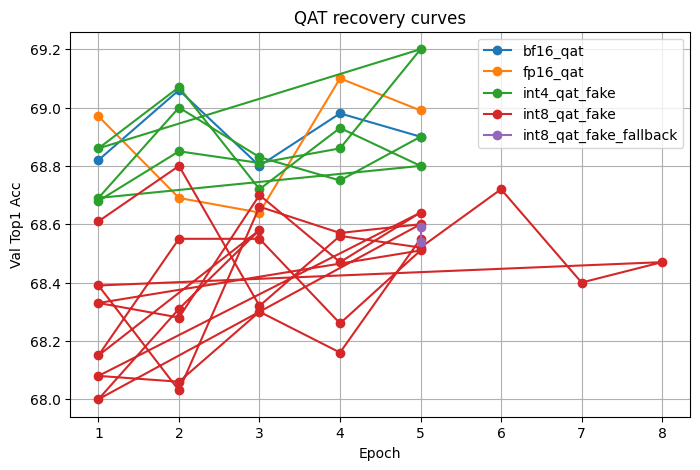

In [ ]:
# QAT Cell 6: quick summary read and a simple plot of val_acc vs epochs per mode (optional)
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(BASE_DIR/"qat_results_summary.csv")
print(df.groupby("mode")["val_acc"].max().reset_index())

# Plot per-mode curves
plt.figure(figsize=(8,5))
for mode, g in df.groupby("mode"):
    plt.plot(g["epoch"], g["val_acc"], marker='o', label=mode)
plt.xlabel("Epoch")
plt.ylabel("Val Top1 Acc")
plt.legend()
plt.grid(True)
plt.title("QAT recovery curves")
plt.savefig(BASE_DIR/"qat_recovery_curves.png", dpi=150)
print("Saved plot to", BASE_DIR/"qat_recovery_curves.png")
plt.show()

##Scaling Laws

Saved scaling plot to /content/drive/MyDrive/quant_task_baseline/scaling_law_ptq_qat.png


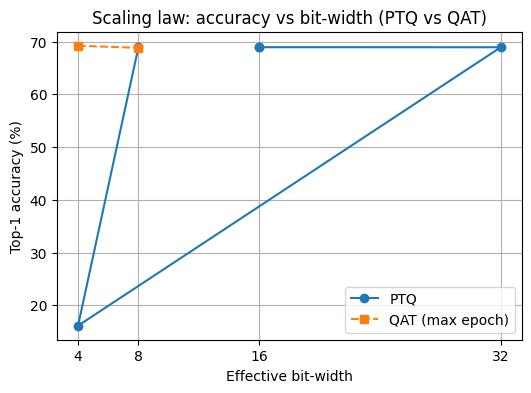

In [ ]:
# Cell A: scaling-law plot (PTQ vs QAT)
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

BASE_DIR = Path("/content/drive/MyDrive/quant_task_baseline")
ptq_csv = BASE_DIR/"ptq_results_summary.csv"
qat_csv = BASE_DIR/"qat_results_summary.csv"

ptq = pd.read_csv(ptq_csv)
qat = pd.read_csv(qat_csv)

# Map modes to effective bit widths
bit_map = {
    "fp32": 32, "fp16": 16, "bf16":16,
    "int8_fx": 8, "int8_qat": 8, "int8_qat_fake": 8,
    "int4_sim": 4, "int4_qat_fake": 4
}

# Prepare PTQ summary: take best acc per mode
ptq_summary = ptq.groupby("mode").agg({"acc":"max"}).reset_index()
ptq_summary["bits"] = ptq_summary["mode"].map(bit_map)

# Prepare QAT summary: take max val_acc per mode (from QAT CSV)
qat_summary = qat.groupby("mode").agg({"val_acc":"max"}).reset_index()
qat_summary["bits"] = qat_summary["mode"].map(bit_map)

# Plot
plt.figure(figsize=(6,4))
# PTQ line
ptq_plot = ptq_summary.dropna(subset=["bits"])
plt.plot(ptq_plot["bits"], ptq_plot["acc"], marker='o', linestyle='-', label='PTQ')
# QAT line (use only modes that map)
qat_plot = qat_summary.dropna(subset=["bits"])
plt.plot(qat_plot["bits"], qat_plot["val_acc"], marker='s', linestyle='--', label='QAT (max epoch)')
plt.xlabel("Effective bit-width")
plt.ylabel("Top-1 accuracy (%)")
plt.title("Scaling law: accuracy vs bit-width (PTQ vs QAT)")
plt.xticks([4,8,16,32])
plt.grid(True)
plt.legend()
plt.savefig(BASE_DIR/"scaling_law_ptq_qat.png", dpi=150)
print("Saved scaling plot to", BASE_DIR/"scaling_law_ptq_qat.png")
plt.show()

In [ ]:
# Cell B: model sizes & latency
import os, torch, time, numpy as np
import pandas as pd
from pathlib import Path

BASE_DIR = Path("/content/drive/MyDrive/quant_task_baseline")

# helper: load weights if present and make a model instance
def load_model_weights(path):
    from importlib import reload
    model = VGG11_BN_CIFAR(num_classes=100)
    w = torch.load(path, map_location='cpu')
    # handle either state_dict or checkpoint dict
    if isinstance(w, dict) and "model_state_dict" in w:
        model.load_state_dict(w["model_state_dict"])
    else:
        model.load_state_dict(w)
    return model

# list candidate files and sizes
candidates = {
    "fp32": BASE_DIR/"vgg11bn_best_float32_weights.pth",
    "fp16_qat_weights": BASE_DIR/"vgg11bn_fp16_qat_weights.pth",
    "bf16_qat_weights": BASE_DIR/"vgg11bn_bf16_qat_weights.pth",
    "ptq_int8_scripted": BASE_DIR/"vgg11bn_int8_scripted.pt",
    "int8_qat_scripted": BASE_DIR/"vgg11bn_int8_qat_scripted.pt",
}

# Prepare file sizes data for DataFrame
file_size_data = []
for name, p in candidates.items():
    size_mb = round(os.path.getsize(p)/(1024*1024), 3) if p.exists() else None
    file_size_data.append({"Model": name, "Size (MB)": size_mb})

df_sizes = pd.DataFrame(file_size_data)
print("File Sizes:")
display(df_sizes) # Use display for better visual output


# Latency: measure on device for float models and for fake-qat models.
def measure_latency_model(model, device, batch_size=1, iters=200, warmup=30):
    model = model.to(device).eval()
    # Use a batch from val loader or create a random tensor
    try:
        dummy = next(iter(val_loader))[0][:batch_size].to(device)
    except StopIteration:
        dummy = torch.randn(batch_size, 3, 32, 32).to(device) # Create dummy tensor if val_loader is exhausted

    with torch.no_grad():
        for _ in range(warmup):
            _ = model(dummy)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        t0 = time.time()
        for _ in range(iters):
            _ = model(dummy)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        elapsed = time.time() - t0
    return (elapsed/iters)*1000.0

latency_data = []

# measure for FP32 baseline (if exists in memory 'model' from restore)
try:
    fp32_latency = measure_latency_model(model, device)
    latency_data.append({"Model": "FP32", "Latency (ms)": round(fp32_latency, 3)})
except Exception as e:
    print("FP32 latency measurement failed:", e)
    latency_data.append({"Model": "FP32", "Latency (ms)": "Failed"})


# measure for FP16 QAT model if exists (load)
if (BASE_DIR/"vgg11bn_fp16_qat_weights.pth").exists():
    try:
        m_fp16 = load_model_weights(BASE_DIR/"vgg11bn_fp16_qat_weights.pth").to(device)
        m_fp16.half()
        lat_fp16 = measure_latency_model(m_fp16, device)
        latency_data.append({"Model": "FP16 (QAT)", "Latency (ms)": round(lat_fp16, 3)})
    except Exception as e:
        print("FP16 latency measure failed:", e)
        latency_data.append({"Model": "FP16 (QAT)", "Latency (ms)": "Failed"})


# For int8 scripted PTQ model, measure CPU latency if available
if (BASE_DIR/"vgg11bn_int8_scripted.pt").exists():
    try:
        q_model = torch.jit.load(str(BASE_DIR/"vgg11bn_int8_scripted.pt")).eval().to('cpu')
        # CPU latency measurement
        def measure_latency_cpu(model, iters=200, warmup=10):
            # Use a batch from val loader or create a random tensor
            try:
                dummy = next(iter(val_loader))[0][:1]
            except StopIteration:
                 dummy = torch.randn(1, 3, 32, 32) # Create dummy tensor if val_loader is exhausted

            with torch.no_grad():
                for _ in range(warmup):
                    _ = model(dummy)
                t0 = time.time()
                for _ in range(iters):
                    _ = model(dummy)
                elapsed = time.time() - t0
            return (elapsed/iters)*1000.0
        lat_int8_cpu = measure_latency_cpu(q_model)
        latency_data.append({"Model": "INT8 (PTQ scripted) CPU", "Latency (ms)": round(lat_int8_cpu, 3)})
    except Exception as e:
        print("INT8 CPU latency failed:", e)
        latency_data.append({"Model": "INT8 (PTQ scripted) CPU", "Latency (ms)": "Failed"})


df_latency = pd.DataFrame(latency_data)
print("\nLatency Measurements:")
display(df_latency) # Use display for better visual output

print("\nDone size & latency measurements.")

File Sizes:


,Model,Size (MB)
0,fp32,36.434
1,fp16_qat_weights,36.433
2,bf16_qat_weights,36.433
3,ptq_int8_scripted,9.189
4,int8_qat_scripted,NaN


FP16 latency measure failed: Input type (float) and bias type (c10::Half) should be the same

Latency Measurements:


,Model,Latency (ms)
0,FP32,1.725
1,FP16 (QAT),Failed
2,INT8 (PTQ scripted) CPU,2.391



Done size & latency measurements.


##Mixed Precision Quantization Analysis

In [ ]:
# Cell C: per-layer activation variance ranking
import torch, numpy as np
import pandas as pd # Import pandas

model_eval = VGG11_BN_CIFAR(num_classes=100).to(device)
# load fp32 weights
ckpt = torch.load(BASE_DIR/"vgg11bn_best.pth", map_location='cpu')
model_eval.load_state_dict(ckpt['model_state_dict'])
model_eval.eval()

# register forward hooks on conv and linear layers to collect activations
layer_names = []
acts = {}
hooks = [] # Initialize the hooks list here

def make_hook(name):
    def hook(module, inp, out):
        # gather mean of absolute activations per batch
        with torch.no_grad():
            if isinstance(out, torch.Tensor):
                x = out.detach().cpu().float()
                # store mean abs and variance
                if name not in acts:
                    acts[name] = {"vals":[]}
                # use mean absolute as sensitivity proxy
                acts[name]["vals"].append(x.abs().mean().item())
    return hook

for n, m in model_eval.named_modules():
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
        layer_names.append(n)
        hooks.append(m.register_forward_hook(make_hook(n))) # Append hook to list


# run over calibration subset (e.g., 500 batches or 2000 images)
count = 0
max_batches = 50
with torch.no_grad():
    for i, (xb,_) in enumerate(calib_loader):
        xb = xb.to(device)
        _ = model_eval(xb)
        if i+1 >= max_batches:
            break

# compute mean stat per layer
sensitivity = []
for name, d in acts.items():
    arr = np.array(d["vals"])
    sensitivity.append((name, arr.mean(), arr.std()))
# sort by mean descending (most active / sensitive)
sensitivity_sorted = sorted(sensitivity, key=lambda x: x[1], reverse=True)

df_sens = pd.DataFrame(sensitivity_sorted, columns=["layer","mean_abs_act","std"])
df_sens.to_csv(BASE_DIR/"layer_sensitivity.csv", index=False)
print("Saved layer sensitivity to", BASE_DIR/"layer_sensitivity.csv")
display(df_sens.head(15)) # Use display instead of print

# Remove hooks to avoid side effects
for h in hooks:
    h.remove()

Saved layer sensitivity to /content/drive/MyDrive/quant_task_baseline/layer_sensitivity.csv


,layer,mean_abs_act,std
0,classifier.4,2.481107,0.046008
1,features.4,0.991922,0.010197
2,features.0,0.595819,0.006313
3,features.8,0.554837,0.007047
4,classifier.1,0.483596,0.009102
5,features.11,0.462955,0.004283
6,features.15,0.271670,0.003421
7,features.22,0.175617,0.004621
8,features.18,0.150720,0.002763
9,features.25,0.047566,0.001012


In [ ]:
# Mixed-precision Cell 2: quantize/dequantize helper and size estimator
import math

def quantize_dequantize_tensor(x, nbits=8, symmetric=True, eps=1e-8):
    """Quantize (symmetric) per-tensor then dequantize (returns float tensor)."""
    if nbits >= 32:
        return x
    if symmetric:
        max_val = x.abs().amax()
        if max_val < eps:
            return x
        qmax = 2**(nbits-1) - 1
        scale = max_val / qmax
        q = torch.clamp((x / scale).round(), -qmax, qmax)
        dq = q * scale
        return dq
    else:
        # asymmetric per-tensor fallback
        min_val = float(x.min()); max_val = float(x.max())
        qmin, qmax = 0, 2**nbits - 1
        scale = (max_val - min_val) / (qmax - qmin + eps)
        zero_point = qmin - round(min_val / (scale+eps))
        q = torch.clamp((x / scale + zero_point).round(), qmin, qmax)
        dq = (q - zero_point) * scale
        return dq

def estimate_model_size_mb(model, per_param_bit_map, default_bits=32):
    """
    Estimate model storage size in MB given a mapping from parameter-name-prefix -> bits.
    per_param_bit_map: dict mapping layer_prefix (e.g., 'features.0') to bits (int).
    default_bits: fallback bits for params not matched.
    """
    total_bits = 0
    for name, p in model.named_parameters():
        assigned_bits = None
        for prefix, bits in per_param_bit_map.items():
            if name.startswith(prefix):
                assigned_bits = bits
                break
        if assigned_bits is None:
            assigned_bits = default_bits
        total_bits += p.numel() * assigned_bits
    total_bytes = total_bits / 8.0
    return total_bytes / (1024**2)  # MB

In [ ]:
# Mixed-precision Cell 3: apply mixed precision (simulate) and evaluate
from copy import deepcopy

def apply_mixed_precision_sim(model_fp32, per_layer_bits, default_bits=32, quantize_activations=True):
    """
    Return a copy of model_fp32 where:
      - weights for layers matched by per_layer_bits prefixes are quantize->dequantized to assigned bits
      - other weights use default_bits
      - optionally attach forward hooks to quantize activations per layer using same mapping
    per_layer_bits: dict prefix -> bits (e.g., {'features.0':16, 'classifier.4':16, 'features.4':4})
    """
    model = deepcopy(model_fp32)  # work on CPU/GPU copy
    model.to(device)
    model.eval()
    # quantize weights per mapping
    with torch.no_grad():
        for name, p in model.named_parameters():
            # find matching prefix (longest prefix match)
            matched_bits = None
            matched_len = -1
            for prefix, bits in per_layer_bits.items():
                if name.startswith(prefix) and len(prefix) > matched_len:
                    matched_bits = bits
                    matched_len = len(prefix)
            if matched_bits is None:
                matched_bits = default_bits
            if matched_bits < 32:
                # dequantize back to float
                dq = quantize_dequantize_tensor(p.data, nbits=matched_bits)
                p.copy_(dq.to(p.dtype))
    # prepare dict to decide activation quantization per module name
    # We'll quantize activations for conv/linear modules using the per_layer_bits mapping for their module name
    hooks = []
    if quantize_activations:
        def make_hook(layer_prefix, bits):
            def hook(module, inp, out):
                if isinstance(out, torch.Tensor) and bits < 32:
                    return quantize_dequantize_tensor(out, nbits=bits)
                return out
            return hook
        # register hooks for modules with names matching prefixes
        for name, mod in model.named_modules():
            # find matching prefix for this module name
            matched_bits = None
            matched_len = -1
            for prefix, bits in per_layer_bits.items():
                if name.startswith(prefix) and len(prefix) > matched_len:
                    matched_bits = bits
                    matched_len = len(prefix)
            if matched_bits is not None and isinstance(mod, (torch.nn.Conv2d, torch.nn.Linear)):
                hooks.append(mod.register_forward_hook(make_hook(name if name in per_layer_bits else prefix, matched_bits)))
    return model, hooks

def evaluate_mixed_config(model_fp32, per_layer_bits, default_bits=32, quantize_activations=True, measure_latency_flag=False):
    model_sim, hooks = apply_mixed_precision_sim(model_fp32, per_layer_bits, default_bits=default_bits, quantize_activations=quantize_activations)
    # evaluate accuracy
    acc = eval_acc(model_sim, val_loader, device)
    # estimate size MB
    size_mb = estimate_model_size_mb(model_sim, per_layer_bits, default_bits=default_bits)
    latency_ms = None
    if measure_latency_flag:
        # measure latency on device (note: simulated quant still runs float ops)
        # use small warmup and runs
        model_sim.eval().to(device)
        dummy = next(iter(val_loader))[0][:1].to(device)
        with torch.no_grad():
            for _ in range(20):
                _ = model_sim(dummy)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            t0 = time.time()
            runs = 200
            for _ in range(runs):
                _ = model_sim(dummy)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            latency_ms = (time.time() - t0)/runs * 1000.0
    # cleanup hooks
    for h in hooks: h.remove()
    return {"acc":acc, "size_mb":size_mb, "latency_ms":latency_ms}

In [ ]:
def eval_acc(model_obj, loader, device_eval):
    model_obj.eval()
    total, correct = 0, 0
    with torch.no_grad():
        model_obj.to(device_eval)
        for xb, yb in loader:
            xb, yb = xb.to(device_eval), yb.to(device_eval)
            out = model_obj(xb)
            _, p = out.max(1)
            correct += p.eq(yb).sum().item()
            total += yb.size(0)
    return 100.0 * correct / total

In [ ]:
# Mixed-precision Cell 4: define strategies and run experiments
# load a fresh FP32 model (from checkpoint)
ckpt = torch.load(BASE_DIR/"vgg11bn_best.pth", map_location='cpu')
model_fp32 = VGG11_BN_CIFAR(num_classes=100).to(device)
model_fp32.load_state_dict(ckpt['model_state_dict'])
model_fp32.eval()

# define prefixes we may use: from sensitivity CSV some entries like 'features.4', 'features.0', 'classifier.4', etc.
# confirm those names exist in model modules
module_names = [n for n,_ in model_fp32.named_modules()]
print("Example module names (first 30):", module_names[:30])

# Strategy A: uniform int8 baseline (all layers int8)
uniform_bits = {}   # empty means default will be applied
uniform_default_bits = 8

# Strategy B: simple (first+last high)
simple_bits = {
    "features.0": 16,      # first conv high (fp16)
    "classifier.4": 16     # last linear high (fp16)
}
simple_default_bits = 4   # others simulated as 4-bit

# Strategy C: adaptive: pick top-k sensitive layers to keep at high bits (e.g., top 3)
k = 3
high_bits = 8
low_bits = 4
topk_layers = top_layers[:k]  # top names from sensitivity csv (most sensitive)
adaptive_bits = {}
for name in topk_layers:
    adaptive_bits[name] = high_bits
# You may also keep first and last high too
adaptive_bits["features.0"] = high_bits
adaptive_bits["classifier.4"] = high_bits

adaptive_default_bits = low_bits

# Evaluate all strategies
results = []
print("Running uniform baseline (all int8)...")
res_uniform = evaluate_mixed_config(model_fp32, uniform_bits, default_bits=uniform_default_bits, quantize_activations=True, measure_latency_flag=True)
res_uniform.update({"strategy":"uniform_all_int8","bits_map":"all=8"})
print(res_uniform)

print("Running simple first+last high (first,last=16, others=4)...")
res_simple = evaluate_mixed_config(model_fp32, simple_bits, default_bits=simple_default_bits, quantize_activations=True, measure_latency_flag=True)
res_simple.update({"strategy":"simple_first_last","bits_map":"features.0=16,classifier.4=16,others=4"})
print(res_simple)

print(f"Running adaptive top-{k} sensitive high (top{k} + first+last = {high_bits} bits)...")
res_adaptive = evaluate_mixed_config(model_fp32, adaptive_bits, default_bits=adaptive_default_bits, quantize_activations=True, measure_latency_flag=True)
res_adaptive.update({"strategy":"adaptive_topk_plus_ends","bits_map":f"top{k}=8,ends=8,others=4","topk":topk_layers})
print(res_adaptive)

# Save results to CSV
import pandas as pd
rows = [res_uniform, res_simple, res_adaptive]
df = pd.DataFrame(rows)
df.to_csv(BASE_DIR/"mixed_precision_results.csv", index=False)
print("Saved mixed precision results to", BASE_DIR/"mixed_precision_results.csv")

Example module names (first 30): ['', 'features', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27']
Running uniform baseline (all int8)...
{'acc': 68.87, 'size_mb': 9.09799575805664, 'latency_ms': 1.5071403980255127, 'strategy': 'uniform_all_int8', 'bits_map': 'all=8'}
Running simple first+last high (first,last=16, others=4)...
{'acc': 57.14, 'size_mb': 4.624946594238281, 'latency_ms': 1.8873834609985352, 'strategy': 'simple_first_last', 'bits_map': 'features.0=16,classifier.4=16,others=4'}
Running adaptive top-3 sensitive high (top3 + first+last = 8 bits)...
{'acc': 64.8, 'size_mb': 4.609531402587891, 'latency_ms': 2.06765294075012

In [ ]:
df

,acc,size_mb,latency_ms,strategy,bits_map,topk
0,68.87,9.097996,1.507140,uniform_all_int8,all=8,NaN
1,57.14,4.624947,1.887383,simple_first_last,"features.0=16,classifier.4=16,others=4",NaN
2,64.80,4.609531,2.067653,adaptive_topk_plus_ends,"top3=8,ends=8,others=4","[classifier.4, features.4, features.0]"


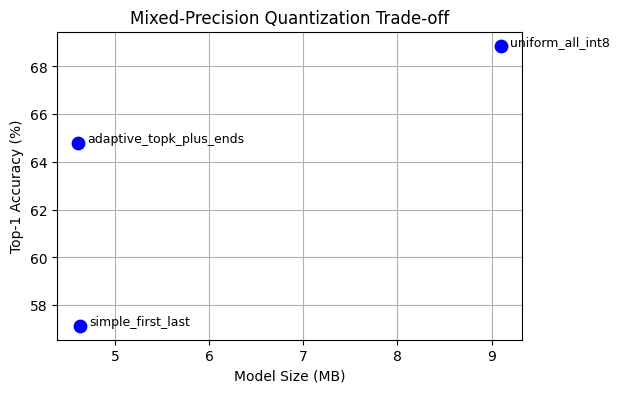

In [ ]:
import pandas as pd, matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/quant_task_baseline/mixed_precision_results.csv")
plt.figure(figsize=(6,4))
plt.scatter(df["size_mb"], df["acc"], c="b", s=80)
for i,row in df.iterrows():
    plt.text(row["size_mb"]+0.1, row["acc"], row["strategy"], fontsize=9)
plt.xlabel("Model Size (MB)")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Mixed-Precision Quantization Trade-off")
plt.grid(True)
plt.show()

k=0: acc=56.98 size=4.57MB latency=2.27ms
k=1: acc=56.98 size=4.57MB latency=2.21ms
k=2: acc=64.80 size=4.61MB latency=2.03ms
k=3: acc=64.80 size=4.61MB latency=2.10ms
k=4: acc=65.58 size=4.75MB latency=2.20ms
k=5: acc=65.47 size=4.88MB latency=2.77ms
k=6: acc=66.07 size=5.16MB latency=2.63ms
k=7: acc=66.43 size=5.72MB latency=2.80ms
k=8: acc=66.36 size=6.84MB latency=3.38ms
k=9: acc=66.74 size=7.97MB latency=3.39ms
k=10: acc=66.84 size=9.10MB latency=3.55ms
Saved sweep results to /content/drive/MyDrive/quant_task_baseline/mixed_precision_sweep_topk.csv
Saved plot to /content/drive/MyDrive/quant_task_baseline/mixed_precision_sweep_acc_vs_size.png


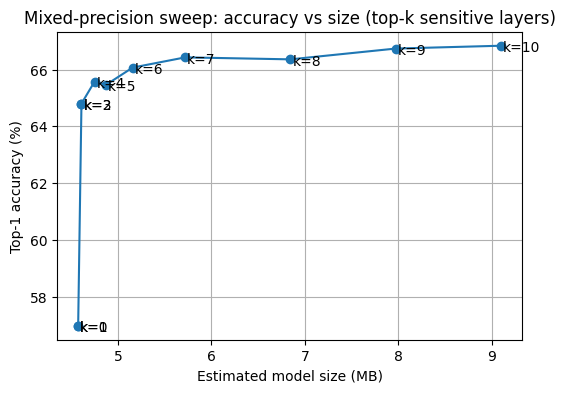

Saved plot to /content/drive/MyDrive/quant_task_baseline/mixed_precision_sweep_acc_vs_k.png


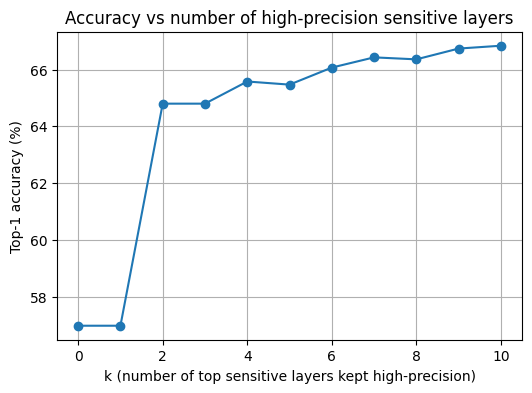

In [ ]:
# Mixed-precision Sweep: vary top-k sensitive layers kept at high precision
import pandas as pd, matplotlib.pyplot as plt, time, os
from copy import deepcopy

# config
BASE_DIR = Path("/content/drive/MyDrive/quant_task_baseline")
model_fp32 = VGG11_BN_CIFAR(num_classes=100).to(device)
ckpt = torch.load(BASE_DIR/"vgg11bn_best.pth", map_location='cpu')
model_fp32.load_state_dict(ckpt['model_state_dict'])
model_fp32.eval()

# sensitivity order (most sensitive first) from your file
sens_df = pd.read_csv(BASE_DIR/"layer_sensitivity.csv")
sensitive_layers = sens_df['layer'].tolist()

# parameters for sweep
max_k = min(10, len(sensitive_layers))   # try up to top-10 or less, adjust if desired
high_bits = 8
low_bits = 4
include_ends = True   # keep first and last in high precision always (set False if you want to test without ends)
first_layer = "features.0"
last_layer  = "classifier.4"

results = []
for k in range(0, max_k+1):
    # build allocation dict
    alloc = {}
    # top-k sensitive
    topk = sensitive_layers[:k]
    for name in topk:
        alloc[name] = high_bits
    # optionally keep first & last at high precision
    if include_ends:
        alloc[first_layer] = high_bits
        alloc[last_layer]  = high_bits
    # evaluate simulated config
    res = evaluate_mixed_config(model_fp32, alloc, default_bits=low_bits, quantize_activations=True, measure_latency_flag=True)
    res.update({"k":k, "topk": topk, "size_mb_est": res["size_mb"]})
    print(f"k={k}: acc={res['acc']:.2f} size={res['size_mb']:.2f}MB latency={res['latency_ms']:.2f}ms")
    results.append(res)

# save and plot
df = pd.DataFrame(results)
df.to_csv(BASE_DIR/"mixed_precision_sweep_topk.csv", index=False)
print("Saved sweep results to", BASE_DIR/"mixed_precision_sweep_topk.csv")

# Plot accuracy vs size
plt.figure(figsize=(6,4))
plt.plot(df['size_mb'], df['acc'], marker='o')
for i,r in df.iterrows():
    plt.text(r['size_mb']+0.02, r['acc']-0.2, f"k={int(r['k'])}")
plt.xlabel("Estimated model size (MB)")
plt.ylabel("Top-1 accuracy (%)")
plt.title("Mixed-precision sweep: accuracy vs size (top-k sensitive layers)")
plt.grid(True)
plt.savefig(BASE_DIR/"mixed_precision_sweep_acc_vs_size.png", dpi=150)
print("Saved plot to", BASE_DIR/"mixed_precision_sweep_acc_vs_size.png")
plt.show()

# Plot accuracy vs k
plt.figure(figsize=(6,4))
plt.plot(df['k'], df['acc'], marker='o')
plt.xlabel("k (number of top sensitive layers kept high-precision)")
plt.ylabel("Top-1 accuracy (%)")
plt.title("Accuracy vs number of high-precision sensitive layers")
plt.grid(True)
plt.savefig(BASE_DIR/"mixed_precision_sweep_acc_vs_k.png", dpi=150)
print("Saved plot to", BASE_DIR/"mixed_precision_sweep_acc_vs_k.png")
plt.show()

##Effect of Outliers on Quantization Performance

In [7]:
# Outlier Cell 1: imports & utilities
import torch, numpy as np, pandas as pd, time, os
from pathlib import Path
from copy import deepcopy
from tqdm import tqdm

BASE_DIR = Path("/content/drive/MyDrive/quant_task_baseline")
BASE_DIR.mkdir(exist_ok=True, parents=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [16]:
# instantiate and load
ckpt_path = BASE_DIR / "vgg11bn_best.pth"
assert ckpt_path.exists(), f"Checkpoint not found at {ckpt_path}"
ckpt = torch.load(ckpt_path, map_location='cpu')


model_eval = VGG11_BN_CIFAR(num_classes=100)
model_eval.load_state_dict(ckpt['model_state_dict'])
model_eval.to(device)
model_eval.eval()

print(f"Loaded checkpoint from {ckpt_path} (epoch {ckpt.get('epoch', 'N/A')}, val_acc {ckpt.get('val_acc', 'N/A')})")

Loaded checkpoint from /content/drive/MyDrive/quant_task_baseline/vgg11bn_best.pth (epoch 49, val_acc 68.92)


In [17]:
# Cell 4: quick evaluation (recompute val accuracy)
import numpy as np, time
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for i, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)
acc = 100.0 * correct / total
print(f"Restored model evaluation - Top1 val acc: {acc:.2f}% (should match ~68.9%)")

Restored model evaluation - Top1 val acc: 68.91% (should match ~68.9%)


In [18]:
# Cell 5: calibration loader & small helper functions
import time, os
import numpy as np
from torch.utils.data import Subset

calib_size = 2000
np.random.seed(42)  # reproducible subset
calib_indices = np.random.choice(len(train_set), size=calib_size, replace=False)
calib_subset = Subset(train_set, calib_indices)
calib_loader = DataLoader(calib_subset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
print("Calibration loader ready with", len(calib_subset))

Calibration loader ready with 2000


In [19]:
# Outlier Cell 2: collect activation absolute maxima per layer across calibration dataset
# Instantiate and load the model for evaluation



layers_to_track = []
for n,m in model_eval.named_modules():
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
        layers_to_track.append(n)

print("Tracking layers:", layers_to_track[:10], "...")

# dict to accumulate per-batch maxima
layer_maxvals = {name: [] for name in layers_to_track}

# forward hooks to record abs max per batch
hooks = []
def make_rec_hook(name):
    def hook(module, inp, out):
        if isinstance(out, torch.Tensor):
            # compute batchwise max abs
            v = out.detach().cpu().abs().amax().item()
            layer_maxvals[name].append(v)
    return hook

for name, mod in model_eval.named_modules():
    if name in layer_maxvals:
        hooks.append(mod.register_forward_hook(make_rec_hook(name)))

# run calibration pass (can be subset)
max_batches = 200  # calibrate on up to 200 batches (~ > 200*BATCH_SIZE images)
with torch.no_grad():
    for i,(xb,_) in enumerate(tqdm(calib_loader, desc="Gathering stats")):
        xb = xb.to(device)
        _ = model_eval(xb)
        if i+1 >= max_batches:
            break

# remove hooks
for h in hooks: h.remove()

# convert to DataFrame and save
layer_stats = []
for name, vals in layer_maxvals.items():
    arr = np.array(vals)
    if arr.size == 0:
        continue
    layer_stats.append({
        "layer": name,
        "count": arr.size,
        "mean_max": float(arr.mean()),
        "std_max": float(arr.std()),
        "min_max": float(arr.min()),
        "max_max": float(arr.max()),
        "p90": float(np.percentile(arr,90)),
        "p95": float(np.percentile(arr,95)),
        "p99": float(np.percentile(arr,99)),
        "p995": float(np.percentile(arr,99.5)),
        "p999": float(np.percentile(arr,99.9)),
        "p9999": float(np.percentile(arr,99.99))
    })
df_layer_stats = pd.DataFrame(layer_stats).sort_values("p99", ascending=False).reset_index(drop=True)
df_layer_stats.to_csv(BASE_DIR/"outlier_layer_stats.csv", index=False)
print("Saved layer stats to", BASE_DIR/"outlier_layer_stats.csv")
df_layer_stats.head(20)

Tracking layers: ['features.0', 'features.4', 'features.8', 'features.11', 'features.15', 'features.18', 'features.22', 'features.25', 'classifier.1', 'classifier.4'] ...


Gathering stats: 100%|██████████| 16/16 [00:01<00:00,  9.92it/s]


Saved layer stats to /content/drive/MyDrive/quant_task_baseline/outlier_layer_stats.csv


,layer,count,mean_max,std_max,min_max,max_max,p90,p95,p99,p995,p999,p9999
0,classifier.4,16,27.551582,2.600103,23.781256,31.607389,30.989275,31.293730,31.544658,31.576023,31.601116,31.606762
1,features.0,16,16.578692,0.279276,16.171595,17.339880,16.913692,17.055706,17.283045,17.311463,17.334197,17.339312
2,features.4,16,13.494539,0.556445,12.907755,15.064948,13.948947,14.230431,14.898045,14.981496,15.048258,15.063279
3,features.8,16,6.505380,0.682666,5.525073,7.967187,7.534876,7.658675,7.905485,7.936336,7.961017,7.966570
4,classifier.1,16,3.929276,0.358957,3.324777,4.679543,4.341806,4.460652,4.635765,4.657654,4.675166,4.679106
5,features.11,16,3.328060,0.385630,2.774265,4.311459,3.770685,4.003835,4.249934,4.280697,4.305307,4.310844
6,features.15,16,2.629017,0.209502,2.226885,2.990282,2.946825,2.974997,2.987225,2.988753,2.989976,2.990251
7,features.18,16,1.378193,0.125227,1.124564,1.623045,1.546571,1.569310,1.612298,1.617671,1.621970,1.622937
8,features.22,16,1.141214,0.102498,0.937024,1.285545,1.275582,1.279017,1.284240,1.284893,1.285415,1.285532
9,features.25,16,0.470797,0.071619,0.388651,0.712445,0.510088,0.567265,0.683409,0.697927,0.709542,0.712155


In [20]:
# Outlier Cell 3: produce per-layer thresholds for a given percentile or global threshold
def get_layer_thresholds_from_stats(percentile=99.5):
    """
    Returns dict: {layer_name: threshold_value} using the collected layer_maxvals.
    percentile: e.g., 99, 99.5, 99.9, 99.99
    """
    thresholds = {}
    for row in layer_stats:  # layer_stats created earlier
        name = row['layer']
        arr = np.array(layer_maxvals[name]) if name in layer_maxvals else np.array([])
        if arr.size == 0:
            thresholds[name] = float(row.get("max_max", 0.0))
        else:
            thresholds[name] = float(np.percentile(arr, percentile))
    return thresholds

# quick check
for p in [99, 99.5, 99.9, 99.99]:
    th = get_layer_thresholds_from_stats(p)
    # show first 5
    print("p=", p, "examples:", list(th.items())[:5])

p= 99 examples: [('features.0', 17.2830451965332), ('features.4', 14.898044729232788), ('features.8', 7.905485010147094), ('features.11', 4.249934303760528), ('features.15', 2.987224614620209)]
p= 99.5 examples: [('features.0', 17.311462593078613), ('features.4', 14.981496405601503), ('features.8', 7.936336207389832), ('features.11', 4.280696684122086), ('features.15', 2.9887530982494352)]
p= 99.9 examples: [('features.0', 17.334196510314943), ('features.4', 15.048257746696473), ('features.8', 7.961017165184021), ('features.11', 4.305306588411332), ('features.15', 2.9899758851528166)]
p= 99.99 examples: [('features.0', 17.339311641693115), ('features.4', 15.063279048442839), ('features.8', 7.966570380687713), ('features.11', 4.31084381687641), ('features.15', 2.9902510122060777)]


In [21]:
# Outlier Cell 4: function to add clipping hooks (per-layer thresholds)
def register_clipping_hooks(model_obj, thresholds, clamp_signed=True):
    """
    thresholds: dict layer_name -> threshold_value (scalar)
    Returns list of hooks to later remove.
    Hooks clamp module outputs (activations) elementwise to [-thr, thr] if clamp_signed True,
    otherwise clamp to [0, thr] (not typical).
    """
    hooks = []
    def make_hook(name, thr):
        thr_val = float(thr)
        def hook(module, inp, out):
            if isinstance(out, torch.Tensor):
                if clamp_signed:
                    return torch.clamp(out, -thr_val, thr_val)
                else:
                    return torch.clamp(out, 0.0, thr_val)
            else:
                return out
        return hook

    for name, mod in model_obj.named_modules():
        if name in thresholds:
            hooks.append(mod.register_forward_hook(make_hook(name, thresholds[name])))
    return hooks

In [22]:
# Outlier Cell 5: PTQ with clipping sweep
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
import torch.ao.quantization as tq

# Define evaluate_model function here to ensure it's available
def evaluate_model(model, loader, device='cuda', max_batches=None):
    """Return (top1_acc, loss_avg) and optionally collect softmax logits if needed."""
    model.eval()
    model.to(device)
    total = 0
    correct = 0
    running_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            if max_batches and i >= max_batches: break
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple): outputs = outputs[0]
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    acc = 100.0 * correct / total if total>0 else 0.0
    return acc


percentiles = [100.0, 99.99, 99.9, 99.5, 99.0, 95.0]  # 100= no clipping (baseline)
results_ptq_clipping = []

# reload fp32 model on CPU for FX flows
fp32 = VGG11_BN_CIFAR(num_classes=100)
fp32.load_state_dict(torch.load(BASE_DIR/"vgg11bn_best.pth", map_location='cpu')["model_state_dict"])
fp32.eval()
torch.backends.quantized.engine = 'fbgemm'  # try fbgemm

for p in percentiles:
    print("\n=== PTQ clipping percentile:", p)
    # compute thresholds
    if p >= 100.0:
        thresholds = {}  # no clipping
    else:
        thresholds = get_layer_thresholds_from_stats(p)
    # prepare fx qconfig
    qconfig = tq.get_default_qconfig("fbgemm")
    qconfig_dict = {"": qconfig}
    example_input = torch.randn(1,3,32,32)

    # prepare_fx
    prepared = prepare_fx(fp32, qconfig_dict, example_input)
    print("Prepared FX model for PTQ.")
    # attach clipping hooks to prepared model for calibration (hooks operate in CPU)
    hooks = register_clipping_hooks(prepared, thresholds, clamp_signed=True)

    # calibrate (forward passes)
    prepared.eval()
    with torch.no_grad():
        for i,(xb,_) in enumerate(tqdm(calib_loader, desc="Calibrating with clipping")):
            xb = xb.to('cpu')
            prepared(xb)
            if i >= 50:  # calibrate on up to 50 batches (tuneable)
                break
    for h in hooks: h.remove()  # remove hooks after calibration

    # convert_fx -> quantized model
    try:
        model_int8 = convert_fx(prepared)
        # evaluate on CPU
        acc = evaluate_model(model_int8, val_loader, device='cpu')
        size_mb = None
        # try save scripted
        qpath = BASE_DIR/f"vgg11bn_int8_ptq_clip_p{p}.pt"
        try:
            torch.jit.script(model_int8).save(qpath)
            size_mb = os.path.getsize(qpath)/(1024*1024)
        except Exception as e:
            print("Could not script/save converted quantized model:", e)
        print(f"PTQ(p={p}) converted int8 acc (CPU): {acc:.2f} sizeMB:{size_mb}")
        results_ptq_clipping.append({"method":"ptq_clip", "percentile":p, "acc":acc, "size_mb":size_mb, "notes":"converted_fx"})
    except Exception as e:
        print("convert_fx failed:", e)
        # fallback: evaluate prepared (fake) model on device with clipping applied during calibration; not ideal but log
        prepared_device = deepcopy(prepared).to(device)
        acc_dev = evaluate_model(prepared_device, val_loader, device)
        print(f"PTQ(p={p}) fallback prepared eval on device acc: {acc_dev:.2f}")
        results_ptq_clipping.append({"method":"ptq_clip", "percentile":p, "acc":acc_dev, "size_mb":None, "notes":f"convert_failed:{e}"})

# save results
pd.DataFrame(results_ptq_clipping).to_csv(BASE_DIR/"ptq_clipping_results.csv", index=False)
print("Saved PTQ clipping results to", BASE_DIR/"ptq_clipping_results.csv")
print(pd.DataFrame(results_ptq_clipping))

/tmp/ipython-input-2492962426.py:48: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(fp32, qconfig_dict, example_input)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping ins


=== PTQ clipping percentile: 100.0
Prepared FX model for PTQ.


Calibrating with clipping: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]
/tmp/ipython-input-2492962426.py:65: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = convert_fx(prepared)
/usr/local/lib/python3.12/dist-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__in

PTQ(p=100.0) converted int8 acc (CPU): 68.96 sizeMB:9.189920425415039

=== PTQ clipping percentile: 99.99
Prepared FX model for PTQ.


Calibrating with clipping: 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


PTQ(p=99.99) converted int8 acc (CPU): 68.75 sizeMB:9.189920425415039

=== PTQ clipping percentile: 99.9
Prepared FX model for PTQ.


Calibrating with clipping: 100%|██████████| 16/16 [00:11<00:00,  1.36it/s]


PTQ(p=99.9) converted int8 acc (CPU): 68.95 sizeMB:9.189850807189941

=== PTQ clipping percentile: 99.5
Prepared FX model for PTQ.


Calibrating with clipping: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


PTQ(p=99.5) converted int8 acc (CPU): 68.79 sizeMB:9.189850807189941

=== PTQ clipping percentile: 99.0
Prepared FX model for PTQ.


Calibrating with clipping: 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


PTQ(p=99.0) converted int8 acc (CPU): 68.77 sizeMB:9.189850807189941

=== PTQ clipping percentile: 95.0
Prepared FX model for PTQ.


Calibrating with clipping: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


PTQ(p=95.0) converted int8 acc (CPU): 68.69 sizeMB:9.189850807189941
Saved PTQ clipping results to /content/drive/MyDrive/quant_task_baseline/ptq_clipping_results.csv
     method  percentile    acc   size_mb         notes
0  ptq_clip      100.00  68.96  9.189920  converted_fx
1  ptq_clip       99.99  68.75  9.189920  converted_fx
2  ptq_clip       99.90  68.95  9.189851  converted_fx
3  ptq_clip       99.50  68.79  9.189851  converted_fx
4  ptq_clip       99.00  68.77  9.189851  converted_fx
5  ptq_clip       95.00  68.69  9.189851  converted_fx


In [26]:
# Outlier Cell 6: simulated INT4 evaluation with clipping sweep
from copy import deepcopy
import torch, numpy as np # Added numpy import

# Define quantize_dequantize_tensor function here
def quantize_dequantize_tensor(x, nbits=8, symmetric=True, eps=1e-8):
    """Quantize (symmetric) per-tensor then dequantize (returns float tensor)."""
    if nbits >= 32:
        return x
    if symmetric:
        max_val = x.abs().amax()
        if max_val < eps:
            return x
        qmax = 2**(nbits-1) - 1
        scale = max_val / qmax
        q = torch.clamp((x / scale).round(), -qmax, qmax)
        dq = q * scale
        return dq
    else:
        # asymmetric per-tensor fallback
        min_val = float(x.min()); max_val = float(x.max())
        qmin, qmax = 0, 2**nbits - 1
        scale = (max_val - min_val) / (qmax - qmin + eps)
        zero_point = qmin - round(min_val / (scale+eps))
        q = torch.clamp((x / scale + zero_point).round(), qmin, qmax)
        dq = (q - zero_point) * scale
        return dq


# Load the FP32 model
BASE_DIR = Path("/content/drive/MyDrive/quant_task_baseline")
ckpt_path = BASE_DIR / "vgg11bn_best.pth"
ckpt = torch.load(ckpt_path, map_location='cpu')
model_fp32 = VGG11_BN_CIFAR(num_classes=100)
model_fp32.load_state_dict(ckpt['model_state_dict'])
model_fp32.to(device)
model_fp32.eval()


def evaluate_sim_int4_with_clipping(thresholds):
    # deep copy FP32 model to avoid corruption
    m = deepcopy(model_fp32).to(device)
    m.eval()
    # quantize weights to 4-bit (symmetric)
    with torch.no_grad():
        for name, p in m.named_parameters():
            p.copy_(quantize_dequantize_tensor(p, nbits=4).to(p.dtype))
    # attach activation clip+quant hooks for conv/linear according to thresholds
    hooks = []
    def make_hook(thr):
        def hook(module, inp, out):
            if isinstance(out, torch.Tensor):
                # clamp then quantize->dequantize to 4-bit
                out_clamped = torch.clamp(out, -thr, thr)
                return quantize_dequantize_tensor(out_clamped, nbits=4)
            return out
        return hook
    for n,mod in m.named_modules():
        if isinstance(mod, (torch.nn.Conv2d, torch.nn.Linear)):
            if n in thresholds:
                hooks.append(mod.register_forward_hook(make_hook(thresholds[n])))
    # eval
    acc = evaluate_model(m, val_loader, device)
    for h in hooks: h.remove()
    return acc

percentiles = [100.0, 99.99, 99.9, 99.5, 99.0, 95.0]
results_int4_clip = []
for p in percentiles:
    print("INT4 sim p=", p)
    if p >= 100.0:
        th = {n: float(np.max(layer_maxvals[n])) for n in layer_maxvals}
    else:
        th = get_layer_thresholds_from_stats(p)
    acc = evaluate_sim_int4_with_clipping(th)
    print("INT4 sim acc with p=",p,":",acc)
    results_int4_clip.append({"method":"int4_sim_clip", "percentile":p, "acc":acc, "size_mb": None})
pd.DataFrame(results_int4_clip).to_csv(BASE_DIR/"int4_sim_clipping_results.csv", index=False)
print("Saved INT4 simulated clipping results to", BASE_DIR/"int4_sim_clipping_results.csv")
print(pd.DataFrame(results_int4_clip))

INT4 sim p= 100.0
INT4 sim acc with p= 100.0 : 16.44
INT4 sim p= 99.99
INT4 sim acc with p= 99.99 : 16.46
INT4 sim p= 99.9
INT4 sim acc with p= 99.9 : 16.4
INT4 sim p= 99.5
INT4 sim acc with p= 99.5 : 16.53
INT4 sim p= 99.0
INT4 sim acc with p= 99.0 : 16.63
INT4 sim p= 95.0
INT4 sim acc with p= 95.0 : 16.8
Saved INT4 simulated clipping results to /content/drive/MyDrive/quant_task_baseline/int4_sim_clipping_results.csv
          method  percentile    acc size_mb
0  int4_sim_clip      100.00  16.44    None
1  int4_sim_clip       99.99  16.46    None
2  int4_sim_clip       99.90  16.40    None
3  int4_sim_clip       99.50  16.53    None
4  int4_sim_clip       99.00  16.63    None
5  int4_sim_clip       95.00  16.80    None
